## Mahjong Tile Detection Inference

### Local Eval

In [2]:
import os

In [ ]:
from ultralytics import YOLO
model = YOLO('flask_app/best_v8.pt')
model.val()

In [40]:
test_image_dir = 'test_real_images'

# Supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# Get a list of files in the directory
files_in_directory = os.listdir(test_image_dir)
image_files = [test_image_dir + '/' + file for file in files_in_directory if os.path.splitext(file)[1].lower() in image_extensions]
print(image_files)
results = model(image_files)

for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    result.show()  # display to screen
    # result.save(filename='result.jpg')  # save to disk
    

['test_real_images/1662456314_742280.png']

0: 416x1024 2 bamboo-6s, 1 bamboo-7, 3 honors-easts, 3 honors-greens, 1 honors-north, 4 honors-reds, 1 honors-west, 1262.4ms
Speed: 34.3ms preprocess, 1262.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 1024)


In [72]:
from inference_sdk import InferenceHTTPClient

test_image_dir = 'test_real_images'

# Supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# Get a list of files in the directory
files_in_directory = os.listdir(test_image_dir)

image_files = [test_image_dir + '/' + file for file in files_in_directory if os.path.splitext(file)[1].lower() in image_extensions and "annotated" not in file]

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="oWpTxAssNuM3zAlX4vlP"
)
result = CLIENT.infer(image_files, model_id="mahjong-tiles-oc9zz/11")

In [73]:
hands = []
for res in result:
    hands.append([pred['class'] for pred in res['predictions']])
for img, hand in zip(image_files, hands):
    print(img, sorted(hand, key=lambda x: (x[1], x[0])), len(hand))

test_real_images/test5.jpg ['2s', '2z', '3z', '3z', '4z', '4z', '4z', '5z'] 8
test_real_images/test4.png ['5s', '6s', '6s', '6s'] 4
test_real_images/IMG_2676.JPG ['1p', '9p', '9s', '1z', '2z', '2z', '3z', '4z', '5z', '7z', '7z'] 11
test_real_images/test3.jpg ['4p', '4p', '5p', '5p', '5p', '5s', '5s', '6s'] 8
test_real_images/test.jpg ['3m', '3m', '4m', '1p', '1p', '2p', '2p', '3p', '3p', '5p', '5p', '1s', '2s', '3s'] 14
test_real_images/20210620014333-1024x576.jpg ['3s', '6s', '6s', '6s'] 4
test_real_images/EaiqNZmVAAAQLGP.jpg ['2p', '2s', '2s', '2s', '6s'] 5
test_real_images/1_oNU7GpZuq9kHravxnvm5DQ.png ['6s', '6s', '6s'] 3


In [74]:
import cv2

def adjust_text_position(image, initial_position, label_size):
    # Initialize new text position based on initial position
    new_position = list(initial_position)

    # Get image dimensions
    img_height, img_width = image.shape[0:2]

    # Padding around text
    padding = 5

    # Adjust text position if it's outside image boundaries
    if new_position[0] < 0:  # Left edge
        new_position[0] = padding
    if new_position[1] < label_size[1]:  # Top edge
        new_position[1] = label_size[1] + padding

    # Check for bottom overlap
    if new_position[1] + label_size[1] > img_height:
        new_position[1] = img_height - label_size[1] - padding
    
    # Return the adjusted position
    return tuple(new_position)

for image_info, image_path in zip(result, image_files):
    # Read the image
    image = cv2.imread(image_path)

    # Define factors for the bounding box thickness and text size
    thickness = 2
    text_scale = 0.6

    # Go through each prediction and draw the box and label it
    for prediction in image_info['predictions']:
        # Extract coordinates and size from the prediction
        cx, cy, width, height = prediction['x'], prediction['y'], prediction['width'], prediction['height']
        label, confidence = prediction['class'], prediction['confidence']

        # Calculate corners of the bounding box
        top_left = (int(cx - width / 2), int(cy - height / 2))
        bottom_right = (int(cx + width / 2), int(cy + height / 2))

        # Draw the bounding box
        image = cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), thickness)

        # Create the label for the bounding box
        label_text = '{}: {:.2f}%'.format(label, confidence * 100)
        label_size, base_line = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, text_scale, thickness)

        # Adjust the text position if it's close to image boundaries
        label_position = adjust_text_position(image, (top_left[0], top_left[1] - base_line), label_size)

        # Draw background for text
        image = cv2.rectangle(image, label_position, (label_position[0] + label_size[0], label_position[1] - label_size[1]), (0, 255, 0), cv2.FILLED)

        # Put the label with the confidence score on the image
        cv2.putText(image, label_text, label_position, cv2.FONT_HERSHEY_SIMPLEX, text_scale, (0, 0, 0), thickness)

    # Save or display the annotated image
    annotated_image_path = image_path.replace('.', '_annotated.')
    cv2.imwrite(annotated_image_path, image)

print("Annotation completed.")

Annotation completed.


In [96]:
from mahjong.hand_calculating.hand import HandCalculator
from mahjong.tile import TilesConverter
from mahjong.hand_calculating.hand_config import HandConfig
from mahjong.meld import Meld
calculator = HandCalculator()

def hand_score(hand):
    man, pin, sou, honors = [], [], [], []
    for tile in hand:
        if "m" in tile:
            man.append(tile[0])
        elif "p" in tile:
            pin.append(tile[0])
        elif "s" in tile:
            sou.append(tile[0])
        elif "z" in tile:
            honors.append(tile)
    tiles = TilesConverter.string_to_136_array(man=man, pin=pin, sou=sou, honors=honors)
    win_tile = tiles[0]
    result = calculator.estimate_hand_value(tiles, win_tile)
    if not result.error: # if winning hand calc
        print(result.han, result.fu)
        print(result.cost['main'])
        print(result.yaku)
        for fu_item in result.fu_details:
            print(fu_item)
    else:
        print("something wrong with the detection...")
        print("ERROR", result.error)

test_real_images/test5.jpg ['2s', '2z', '3z', '3z', '4z', '4z', '4z', '5z'] 8


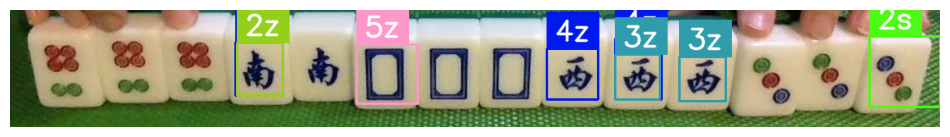

test_real_images/test4.png ['5s', '6s', '6s', '6s'] 4


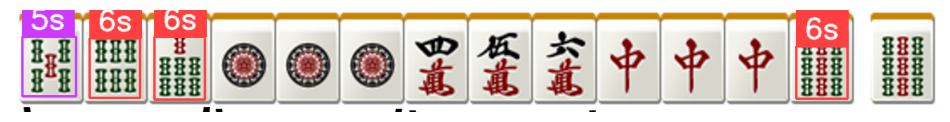

test_real_images/IMG_2676.JPG ['1p', '9p', '9s', '1z', '2z', '2z', '3z', '4z', '5z', '7z', '7z'] 11


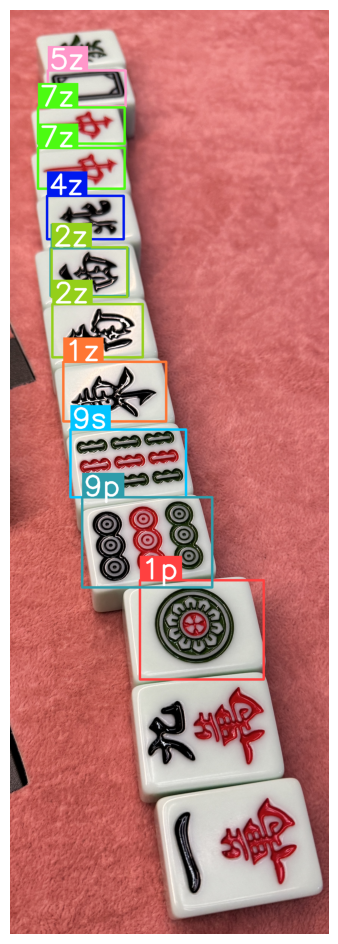

test_real_images/test3.jpg ['4p', '4p', '5p', '5p', '5p', '5s', '5s', '6s'] 8


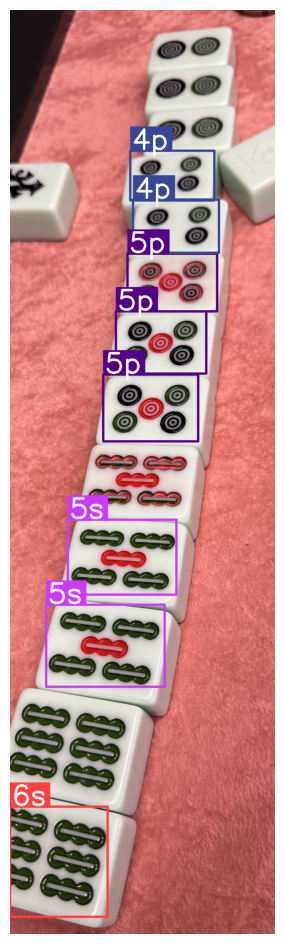

test_real_images/test.jpg ['3m', '3m', '4m', '1p', '1p', '2p', '2p', '3p', '3p', '5p', '5p', '1s', '2s', '3s'] 14
something wrong with the detection...
ERROR hand_not_winning


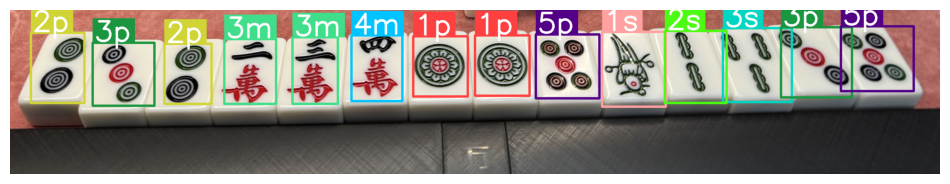

test_real_images/20210620014333-1024x576.jpg ['3s', '6s', '6s', '6s'] 4


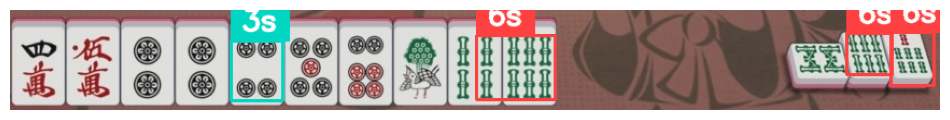

test_real_images/EaiqNZmVAAAQLGP.jpg ['2p', '2s', '2s', '2s', '6s'] 5


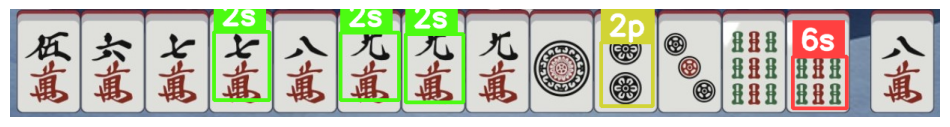

test_real_images/1_oNU7GpZuq9kHravxnvm5DQ.png ['6s', '6s', '6s'] 3


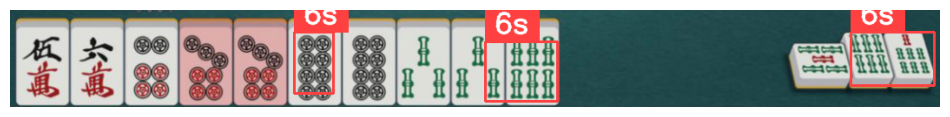

In [97]:
import cv2
import supervision as sv
from inference.models.utils import get_roboflow_model



def get_scale_factor(image_size, reference_size=800, base_scale=0.8, base_thickness=2):
    # Calculate the scale factor based on the image size compared to a reference size
    scale_factor = max(image_size) / reference_size
    scaled_text_scale = max(base_scale * scale_factor, base_scale)  # Ensure minimum scale
    scaled_text_thickness = max(int(base_thickness * scale_factor), base_thickness)  # Ensure minimum thickness
    return scaled_text_scale, scaled_text_thickness

for img, resp in zip(image_files, result):
    image = cv2.imread(img)
    # Get scale and thickness based on image size
    text_scale, text_thickness = get_scale_factor(image.shape[:2])
    
    detections = sv.Detections.from_inference(resp)
    bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=text_thickness)
    label_annotator = sv.LabelAnnotator(text_scale=text_scale, text_thickness=text_thickness)
    # conf_annotator = sv.PercentageBarAnnotator()
    
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)
    # annotated_image = conf_annotator.annotate(scene=annotated_image, detections=detections)
    hand = sorted([pred['class'] for pred in resp['predictions']], key=lambda x: (x[1], x[0]))
    print(img, hand, len(hand))
    if len(hand) == 14:
        hand_score(hand)
    sv.plot_image(annotated_image)